In [1]:
import json, os
import cv2
import torch
from multiprocessing import Pool, Manager
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.akpd import AKPD
from aquabyte.template_matching import find_matches_and_homography
from aquabyte.biomass_estimator import NormalizeCentered2D, NormalizedStabilityTransform, ToTensor, Network
from aquabyte.akpd_scorer import generate_confidence_score
from keras.models import load_model
import boto3
import pandas as pd
import numpy as np
import plotly.express as px
import time
from matplotlib import pyplot as plt

from collections import defaultdict
import datetime as dt
import json
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict



Using TensorFlow backend.


In [2]:
s3_access_utils = S3AccessUtils('/root/data')
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))



In [ ]:
events = [
    {
        'start_date': '2019-10-31',
        'end_date': '2019-10-31',
        'pens': [56, 57, 58, 59, 60],
        'message': 'YOLOv3 version 1 released'
    },
    {
        'start_date': '2019-11-20',
        'end_date': '2019-11-26',
        'pens': [56, 57, 58, 59, 60],
        'message': 'Delousing Event'
    },
    {
        'start_date': '2019-12-17',
        'end_date': '2019-12-17',
        'pens': [56],
        'message': 'New enclosure with circular calibration'
    },
    {
        'start_date': '2019-12-17',
        'end_date': '2019-12-17',
        'pens': [57],
        'message': 'New enclosure with circular calibration'
    },
    {
        'start_date': '2019-12-20',
        'end_date': '2019-12-20',
        'pens': [57],
        'message': 'New enclosure with circular calibration'
    },
    {
        'start_date': '2020-01-24',
        'end_date': '2020-01-24',
        'pens': [58],
        'message': 'New enclosure with circular calibration'
    },
    {
        'start_date': '2019-10-08',
        'end_date': '2019-10-08',
        'pens': [59],
        'message': 'New enclosure with circular calibration'
    },
    {
        'start_date': '2020-01-24',
        'end_date': '2020-01-24',
        'pens': [59],
        'message': 'New enclosure with circular calibration'
    },
    {
        'start_date': '2020-01-17',
        'end_date': '2020-01-17',
        'pens': [56, 57, 58, 59, 60],
        'message': 'YOLOv3 version 2 released'
    }
]
    

In [ ]:
def generate_trend(pen_id, group_id, events):
    
    # extract dataframe
    query = """
        SELECT * FROM
        prod.biomass_computations bc
        WHERE bc.pen_id={0}
        AND (bc.group_id='{1}' OR bc.group_id='{0}')
        AND bc.captured_at between '2019-10-01' and '2020-01-31'
        AND bc.akpd_score > 0.9;
    """.format(pen_id, group_id)

    df = rds_access_utils.extract_from_database(query)


    # get daily averages and sample sizes
    df.index = pd.to_datetime(df.captured_at)
    tdf = df.estimated_weight_g.resample('D').agg(lambda x: x.mean())
    rdf = df.estimated_weight_g.resample('D').agg(lambda x: x.shape[0])

    # generate plots
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].plot(tdf.index, tdf.values, color='blue')
    axes[0].grid()
    axes[0].set_title('Pen ID: {}, Raw Daily Weight Averages'.format(pen_id))

    axes[1].plot(rdf.index, rdf.values, color='blue')
    axes[1].set_title('Pen ID: {}, Daily Sample Size'.format(pen_id))
    axes[1].grid()

    # mark events
    idx = 0
    for e in events:
        if pen_id in e['pens']:
            start_date, end_date = e['start_date'], e['end_date']
            for i in [0, 1]:
                if start_date == end_date:
                    axes[i].axvline(start_date, linestyle='--', color='C{}'.format(idx), label=e['message'])
                    idx += 1
                else:
                    axes[i].axvline(start_date, linestyle='--', color='C{}'.format(idx), label='{}: START'.format(e['message']))
                    idx += 1
                    axes[i].axvline(end_date, linestyle='--', color='C{}'.format(idx), label='{}: END'.format(e['message']))
                    idx += 1

    for i in [0, 1]:
        axes[i].legend()
    plt.show()

NameError: name 'events' is not defined

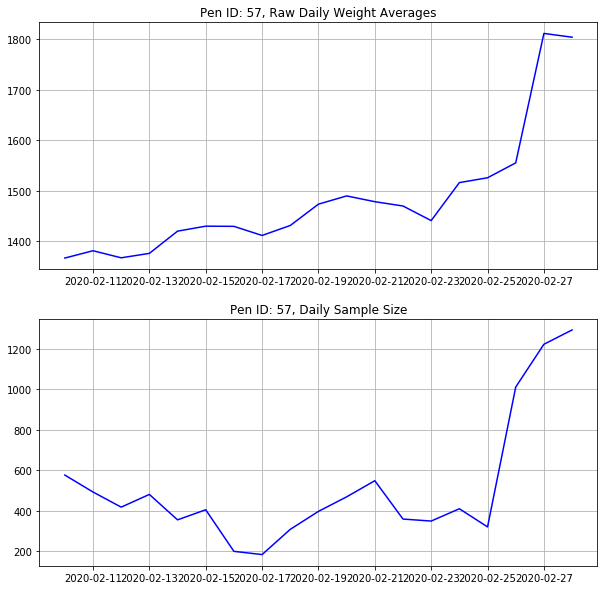

In [6]:
# extract dataframe
# pen_id, group_id = 57, '57_t3_akpd'
pen_id, group_id = 57, '57'
query = """
    SELECT * FROM
    prod.biomass_computations bc
    WHERE bc.pen_id={0}
    AND (bc.group_id='{1}' OR bc.group_id='{0}')
    AND bc.captured_at between '2020-02-01' and '2020-02-29'
    AND bc.akpd_score > 0.9;
""".format(pen_id, group_id)

df = rds_access_utils.extract_from_database(query)
df = df.sort_values('captured_at')


# get daily averages and sample sizes
df.index = pd.to_datetime(df.captured_at)
tdf = df.estimated_weight_g.resample('D').agg(lambda x: x.mean())
rdf = df.estimated_weight_g.resample('D').agg(lambda x: x.shape[0])

# generate plots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].plot(tdf.index, tdf.values, color='blue')
axes[0].grid()
axes[0].set_title('Pen ID: {}, Raw Daily Weight Averages'.format(pen_id))

axes[1].plot(rdf.index, rdf.values, color='blue')
axes[1].set_title('Pen ID: {}, Daily Sample Size'.format(pen_id))
axes[1].grid()

# mark events
idx = 0
for e in events:
    if pen_id in e['pens']:
        start_date, end_date = e['start_date'], e['end_date']
        for i in [0, 1]:
            if start_date == end_date:
                axes[i].axvline(start_date, linestyle='--', color='C{}'.format(idx), label=e['message'])
                idx += 1
            else:
                axes[i].axvline(start_date, linestyle='--', color='C{}'.format(idx), label='{}: START'.format(e['message']))
                idx += 1
                axes[i].axvline(end_date, linestyle='--', color='C{}'.format(idx), label='{}: END'.format(e['message']))
                idx += 1

for i in [0, 1]:
    axes[i].legend()
plt.show()

In [7]:
tdf = pd.DataFrame()
tdf['base_key'] = sorted(df.left_crop_url.apply(lambda x: '/'.join(x.split('/')[3:-1])).unique().tolist())

In [9]:
tdf.to_csv('/root/data/alok/biomass_estimation/playground/vikane_data_base_keys_feb.csv')

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df.estimated_weight_g.resample('D').apply(lambda x: x.mean()))
plt.plot(df.estimated_weight_g.rolling('3D').mean().resample('D').apply(lambda x: x[-1] if x.shape[0] else None))
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
kdf = df.estimated_weight_g.rolling('5D').mean().resample('D').apply(lambda x: x[-1] if x.shape[0] else None)
plt.hist(kdf[:'2019-12-15'].diff(1) / kdf[:'2019-12-15'])
plt.show()

In [ ]:
generate_trend(56, '56_t3_akpd', events)

In [ ]:
generate_trend(57, '57_t3_akpd', events)

In [ ]:
generate_trend(58, '58_t3_akpd', events)

In [ ]:
generate_trend(59, '59_t3_akpd', events)

In [ ]:
generate_trend(60, '60_t3_akpd', events)

In [ ]:
generate_trend(73, '73_t3_akpd', events)

In [ ]:
dates = sorted(list(set(df.index.date.astype(str))))
N = 4
for idx in range(len(dates)-N-1):
    start_date, end_date, date = dates[idx], dates[idx+N], dates[idx+N+1]
    mean_adjustment = df[date].estimated_weight_g.mean() - df[start_date:end_date].estimated_weight_g.mean()
    x = np.percentile(df[start_date:end_date].estimated_weight_g + mean_adjustment, list(range(100)))
    y = np.percentile(df[date].estimated_weight_g, list(range(100)))
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].scatter(x[1:99], y[1:99])
    axes[0].plot([x[1], x[99]], [x[1], x[99]], color='red')
    axes[0].set_title(date)
    axes[0].grid()
    
    lower_bound = int(df[start_date:date].estimated_weight_g.min() * 0.8)
    upper_bound = int(df[start_date:date].estimated_weight_g.max() * 1.2)
    
    axes[1].hist(df[start_date:end_date].estimated_weight_g, bins=list(np.arange(lower_bound, upper_bound, 100)), color='blue', alpha=0.5, density=True)
    axes[1].hist(df[date].estimated_weight_g, bins=list(np.arange(lower_bound, upper_bound, 100)), color='red', alpha=0.5, density=True)
    axes[1].set_title(date)
    axes[1].grid()
    
    print(np.mean(np.square((x[1:99] - y[1:99]) / y[1:99])) ** 0.5)
    print(mean_adjustment / df[start_date:end_date].estimated_weight_g.mean())
    
    plt.show()

In [ ]:
def compute_growth_rate(tdf, rdf, start_date, end_date):
    x_values = [(dt.datetime.strptime(k, '%Y-%m-%d') - \
                 dt.datetime.strptime(start_date, '%Y-%m-%d')).days \
                 for k in tdf.index.date.astype(str)]
    X = np.array(x_values).reshape(-1, 1)
    y = np.log(tdf.values)
    reg = LinearRegression().fit(X, y, sample_weight=rdf.values)
    growth_rate = reg.coef_[0]
    trend_score = reg.score(X, y, sample_weight=rdf.values)
    return growth_rate, trend_score


def compute_distribution_confidence(df, start_date, end_date, date):
    mean_adjustment = df[date:date].estimated_weight_g.mean() - df[start_date:end_date].estimated_weight_g.mean()
    x = np.percentile(df[start_date:end_date].estimated_weight_g + mean_adjustment, list(range(100)))
    y = np.percentile(df[date:date].estimated_weight_g, list(range(100)))
    distribution_confidence = np.mean(np.square((x[1:99] - y[1:99]) / y[1:99])) ** 0.5
    return distribution_confidence


# NOTE: we need to think more carefully about this to understand how distribution 
# confidence and trend score affect the minimum sample size we want...
def compute_minimum_sample_size(distribution_confidence, trend_score):
    return 5000
    

def compute_smart_average(df, tdf, rdf, date, distribution_confidence, growth_rate, 
                          trend_score, window_size_d, bucket_size=0.1):
    
    dates = sorted(list(tdf.index.date.astype(str)))
    if len(dates) == 1:
        growth_rate = 0.0
    minimum_sample_size = compute_minimum_sample_size(distribution_confidence, trend_score)
    x_values = [(dt.datetime.strptime(date, '%Y-%m-%d') - \
                 dt.datetime.strptime(k, '%Y-%m-%d')).days \
                 for k in tdf.index.date.astype(str)]
    X = np.array(x_values).reshape(-1, 1)
    Y = tdf.values
    N = rdf.values
    
    for i in range(3, window_size_d):
        if N[np.abs(np.squeeze(X)) <= i].sum() >= minimum_sample_size:
            break
    N[np.abs(np.squeeze(X)) > i] = 0
    
    smart_average = 0.0
    sample_size = 0.0
    adj_weights = []
    total_days = 0
    for x, y, n, this_date in zip(X, Y, N, dates):
        smart_average += np.exp(x * growth_rate) * y * n
        sample_size += n
        if n > 0:
            adj_weights_for_date = \
                list(np.exp(x * growth_rate) * df[this_date:this_date].estimated_weight_g.values)
            adj_weights.extend(adj_weights_for_date)
            total_days += 1
        
    smart_average /= sample_size
    
    adj_weights = np.array(adj_weights)
    distribution = {}
    buckets = [round(x, 1) for x in np.arange(0.0, 1e-3 * adj_weights.max(), bucket_size)]
    for b in buckets:
        low, high = 1e3 * b, 1e3 * (b + bucket_size)
        count = adj_weights[(adj_weights >= low) & (adj_weights < high)].shape[0]
        distribution[b] = count / sample_size
    
    output = {
        'weightMovingAvg': smart_average,
        'weightMovingDist': distribution,
        'numMovingAvgBatiFish': sample_size,
        'numMovingAvgLookbackDays': total_days,
        'dailyGrowthRate': growth_rate
    }
    
    return output


def compute_date_range(historical_dates, date, window_size_d):
    FMT = '%Y-%m-%d'
    max_num_days = 0
    start_date, end_date = None, None
    for i in range(window_size_d // 2 + 1):
        lower_bound_date = (dt.datetime.strptime(date, FMT) - dt.timedelta(days=window_size_d-1) + \
                            dt.timedelta(days=i)).strftime(FMT)
        upper_bound_date = (dt.datetime.strptime(date, FMT) + dt.timedelta(days=i)).strftime(FMT)
        num_days = ((np.array(historical_dates)  >= lower_bound_date) & \
                    (np.array(historical_dates) <= upper_bound_date)).sum()
        if num_days >= max_num_days:
            start_date, end_date = lower_bound_date, upper_bound_date
            max_num_days = num_days
    
    return start_date, end_date


def compute_metrics(date, records_json, window_size_d=7):
    
    records = json.loads(records_json)
    
    dts, vals = [], []
    for iter_date in records:
        for val in records[iter_date]:
            dts.append(iter_date)
            vals.append(val)

    df = pd.DataFrame(vals, index=pd.to_datetime(dts), columns=['estimated_weight_g'])
    
    # get raw statistics
    raw_avg_weight = df[date:date].estimated_weight_g.mean()
    raw_sample_size = df[date:date].shape[0]
    
    # compute relevant date range
    historical_dates = sorted(list(set(df.index.date.astype(str))))
    start_date, end_date = compute_date_range(historical_dates, date, window_size_d)
    
    rdf = df[start_date:end_date].estimated_weight_g.resample('D').agg(lambda x: x.shape[0])
    tdf = df[start_date:end_date].estimated_weight_g.resample('D').agg(lambda x: x.mean())
    tdf = tdf[rdf > 0].copy(deep=True)
    rdf = rdf[rdf > 0].copy(deep=True)
    
    growth_rate, trend_score, distribution_confidence = None, None, None
    if start_date < end_date:
        growth_rate, trend_score = compute_growth_rate(tdf, rdf, start_date, end_date)
        distribution_confidence = compute_distribution_confidence(df, start_date, end_date, date)
    smart_average = compute_smart_average(df, tdf, rdf, date, 
                                          distribution_confidence, growth_rate, 
                                          trend_score, window_size_d)
    metadata = {
        'growth_rate': growth_rate,
        'trend_score': trend_score,
        'distribution_confidence': distribution_confidence
    }

    return smart_average, metadata


In [ ]:
# extract dataframe
pen_id, group_id = 60, '60_t3_akpd'
query = """
    SELECT * FROM
    prod.biomass_computations bc
    WHERE bc.pen_id={0}
    AND (bc.group_id='{1}' OR bc.group_id='{0}')
    AND bc.captured_at between '2019-10-01' and '2019-11-15'
    AND bc.akpd_score > 0.9;
""".format(pen_id, group_id)

df = rds_access_utils.extract_from_database(query)
df = df.sort_values('captured_at')


# get daily averages and sample sizes
df.index = pd.to_datetime(df.captured_at)
records = defaultdict(list)
for date in sorted(list(set(df.index.date.astype(str)))):
    records[date].extend(df[date].estimated_weight_g.values.tolist())
    
records_json = json.dumps(records)




In [ ]:
dates = sorted(list(set(df.index.date.astype(str))))
raw_avg_weights, raw_sample_sizes, growth_rates, trend_scores, smart_averages, distribution_confidences = [], [], [], [], [], []
for date in dates:
    print(date)
    smart_average, metadata \
        = compute_metrics(date, records_json)
    smart_averages.append(smart_average['weightMovingAvg'])
    raw_avg_weights.append(df[date].estimated_weight_g.mean())


In [ ]:
import plotly.graph_objects as go


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=raw_avg_weights,
                    mode='lines+markers',
                    name='Raw Average Weight'))
fig.add_trace(go.Scatter(x=x_values, y=[x[0] for x in smart_averages],
                    mode='lines',
                    name='Smart Average Weight'))

fig.update_layout(title='Average Weight vs. Time',
                   xaxis_title='Date',
                   yaxis_title='Average Weight (g)')
fig.show()

In [ ]:
dates = list(x_values.date.astype(str))
kdf = pd.DataFrame({
    'date': dates,
    'raw_avg_weight': raw_avg_weights,
    'smart_avg_weight': [x[0] for x in smart_averages]
})

In [ ]:
kdf.to_csv('/root/data/alok/biomass_estimation/playground/vikane_data.csv')

In [ ]:
plt.figure(figsize=(20, 10))
x_values = df.estimated_weight_g.resample('D').agg(lambda x: x.shape[0]).dropna().index
y = df.estimated_weight_g.resample('D').agg(lambda x: x.shape[0]).dropna().values
plt.plot(x_values, y)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
x_values = df.estimated_weight_g.resample('D').agg(lambda x: x.mean()).dropna().index
plt.plot(x_values, raw_avg_weights)
plt.plot(x_values, smart_averages)
plt.grid()
plt.show()

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 27))
x_values = df.estimated_weight_g.resample('D').agg(lambda x: x.mean()).dropna().index
axes[0].plot(x_values, raw_avg_weights)
axes[0].plot(x_values, smart_averages)
axes[1].plot(x_values, growth_rates)
axes[2].plot(x_values, trend_scores)
axes[3].plot(x_values, distribution_confidences)
for i, title in zip([0, 1, 2, 3], ['Raw avg. weight', 'Growth rate', 'Local trend score', 'Distribution Confidence']):
    axes[i].grid()
    axes[i].set_title(title)
plt.grid()
plt.show()
